In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import datetime

from sklearn.linear_model import LinearRegression

In [2]:
suptitle_size = 20
title_size = 15
label_size = 14
start_year = 1940
end_year = 2023
number_of_years = end_year - start_year
number_of_months = number_of_years * 12

hovmoeller_temp_levels = [-2, -1, -0.5, -0.25, 0.25, 0.5, 1, 2]
hovmoeller_rel_levels = [-8, -6, -4, -2, -1, 1, 2, 4, 6, 8]
hovmoeller_spec_levels = [-0.5, -0.4, -0.3, -0.2, -0.1, 0.1, 0.2, 0.3, 0.4, 0.5]

### Zagreb data

In [3]:
file = nc.Dataset('zg_temp_00.nc', 'r')
zg_temp_00 = file.variables["t"][:].data - 273.15
levels = file.variables["level"][:].data
file.close()

file = nc.Dataset('zg_temp_12.nc', 'r')
zg_temp_12 = file.variables["t"][:].data - 273.15
file.close()

file = nc.Dataset('zg_rel_00.nc', 'r')
zg_rel_00 = file.variables["r"][:].data
file.close()

file = nc.Dataset('zg_rel_12.nc', 'r')
zg_rel_12 = file.variables["r"][:].data
file.close()

file = nc.Dataset('zg_spec_00.nc', 'r')
zg_spec_00 = file.variables["q"][:].data * 1000
file.close()

file = nc.Dataset('zg_spec_12.nc', 'r')
zg_spec_12 = file.variables["q"][:].data * 1000
file.close()

### Zadar data

In [4]:
file = nc.Dataset('zd_temp_00.nc', 'r')
zd_temp_00 = file.variables["t"][:].data - 273.15
file.close()

file = nc.Dataset('zd_temp_12.nc', 'r')
zd_temp_12 = file.variables["t"][:].data - 273.15
file.close()

file = nc.Dataset('zd_rel_00.nc', 'r')
zd_rel_00 = file.variables["r"][:].data
file.close()

file = nc.Dataset('zd_rel_12.nc', 'r')
zd_rel_12 = file.variables["r"][:].data
file.close()

file = nc.Dataset('zd_spec_00.nc', 'r')
zd_spec_00 = file.variables["q"][:].data * 1000
file.close()

file = nc.Dataset('zd_spec_12.nc', 'r')
zd_spec_12 = file.variables["q"][:].data * 1000
file.close()

In [5]:
def get_averaged_differences(values):
    difference_slopes = []
    for level in range(len(levels)):
        
        averages_by_year = []
        sum = 0
        counter = 0

        for time_step in range(len(values)): 
            sum += values[time_step][level][0][0] 

            if (time_step < 12 and counter == 11 or time_step > 12 and counter == 12):
                averages_by_year.append(sum)
                sum = 0
                counter = 0
            counter += 1

        differences = []

        for year in range(len(averages_by_year) - 1):
            differences.append(averages_by_year[year + 1] - averages_by_year[year])
        
        difference_slopes.append(np.average(differences))
        
    return difference_slopes

In [6]:
def get_averaged_differences2(values):
    difference_slopes = []
    
    for level in range(len(levels)):
        
        averages_by_year = []
        sum = 0
        counter = 0

        for time_step in range(len(values)):
            sum += values[time_step][level][0][0]
            
            if (time_step < 12 and counter == 11 or time_step > 12 and counter == 12):
                averages_by_year.append(sum/12)
                sum = 0
                counter = 0
                
            counter += 1
            
        anomalies = []

        for year in range(len(averages_by_year)):
            anomalies.append(averages_by_year[year] - np.average(averages_by_year))
            
        years = np.arange(1940, 2023, 1).reshape(-1, 1)
        
        model = LinearRegression().fit(years, anomalies)
        difference_slopes.append(model.coef_)
        
    return difference_slopes

In [7]:
def get_climatology_by_level(values):
    climatology_by_level = []

    for level in range(len(levels)):
        level_total = []
        for time_step in range(len(values)):
            level_total.append(values[time_step][level][0][0])
        
        climatology_by_level.append(np.mean(level_total))

    return climatology_by_level

In [8]:
def get_anomalies_by_year_and_level(values):

    climatology_by_level = get_climatology_by_level(values)
    anomalies_by_level = []

    for level in range(len(levels)):
        
        yearly_averages = []
        sum = 0
        counter = 0

        for time_step in range(len(values)):
            sum += values[time_step][level][0][0]
            if (time_step < 12 and counter == 11 or time_step > 12 and counter == 12):
                yearly_averages.append(sum/12 - climatology_by_level[level])
                sum = 0
                counter = 0
            counter += 1

        anomalies_by_level.append(yearly_averages)

    return anomalies_by_level

In [9]:
def graph_trend(temp, rel, spec, title):

    dashed_line_color = "#888"

    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    fig.suptitle(title, fontsize=suptitle_size)

    ax[0].plot(get_averaged_differences(temp), levels)
    ax[0].invert_yaxis()
    ax[0].axvline(0, color=dashed_line_color, linestyle="dashed")
    ax[0].set_xlim(-1, 1)

    ax[1].plot(get_averaged_differences(rel), levels)
    ax[1].invert_yaxis()
    ax[1].axvline(0, color=dashed_line_color, linestyle="dashed")
    ax[1].set_xlim(-1, 1)


    ax[2].plot(get_averaged_differences(spec), levels)
    ax[2].invert_yaxis()
    ax[2].axvline(0, color=dashed_line_color, linestyle="dashed")

    ax[0].set_title("Temperatura", fontsize=title_size)
    ax[0].set_xlabel(r"Promjena [$^{\circ}$ C]", fontsize=label_size)
    ax[0].set_ylabel("Tlak [hPa]", fontsize=label_size)

    ax[1].set_title("Relativna vlažnost", fontsize=title_size)
    ax[1].set_xlabel(r"Promjena [$\%$]", fontsize=label_size)
    ax[1].set_ylabel("Tlak [hPa]", fontsize=label_size)

    ax[2].set_title("Specifična vlažnost", fontsize=title_size)
    ax[2].set_xlabel(r"Promjena [$g/kg$]", fontsize=label_size)
    ax[2].set_ylabel("Tlak [hPa]", fontsize=label_size)

In [10]:
def graph_hovmoeller(values, cmap_levels, title, cmap_label):
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    date_list = []

    for year in range(start_year, end_year):
        date = datetime.date(year, 1, 1)
        date_list.append(date)
            
    x_values = np.arange(len(date_list))
    [X, Y] = np.meshgrid(x_values, levels)
            
    plt.gcf().autofmt_xdate()
    ax.invert_yaxis()

    tick_indices = np.arange(0, len(date_list), 5)
    ax.set_xticks(tick_indices)
    ax.set_xticklabels([date_list[i].strftime("%Y") for i in tick_indices])

    ax.set_title(title)
    ax.set_xlabel("Godina", fontsize=label_size)
    ax.set_ylabel("Tlak (hPa)", fontsize=label_size)

    cmap = plt.get_cmap("RdBu")

    contour = ax.contourf(X, Y, get_anomalies_by_year_and_level(values), cmap=cmap.reversed(), levels=cmap_levels)
    fig.colorbar(contour, label=cmap_label)

## Zagreb 00 UTC

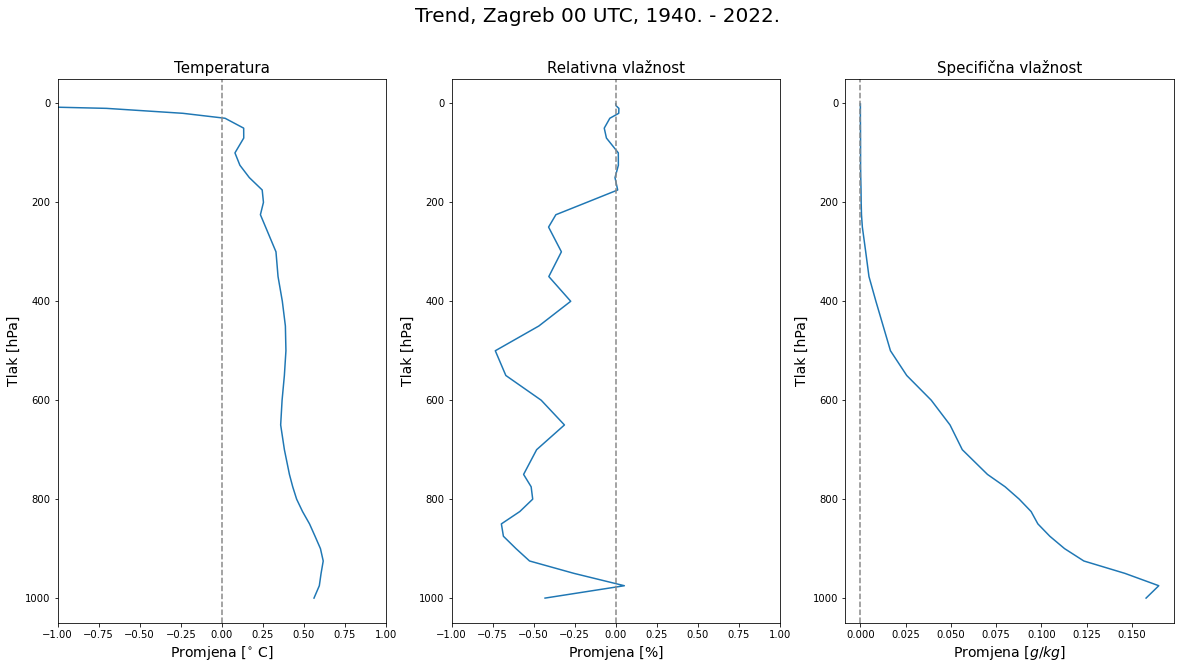

In [11]:
graph_trend(zg_temp_00, zg_rel_00, zg_spec_00, "Trend, Zagreb 00 UTC, 1940. - 2022.")

plt.savefig("zg_00.png")

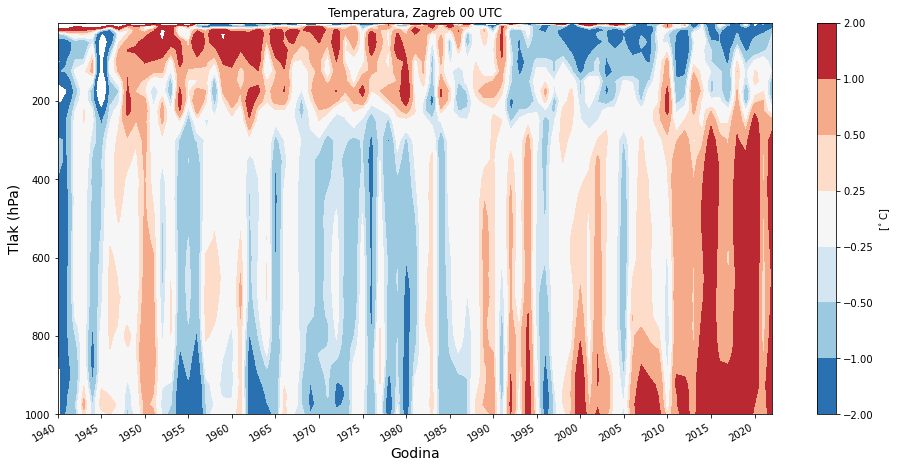

In [12]:
graph_hovmoeller(zg_temp_00, cmap_levels=hovmoeller_temp_levels, title="Temperatura, Zagreb 00 UTC", cmap_label=r"[$^{\circ}$ C]")

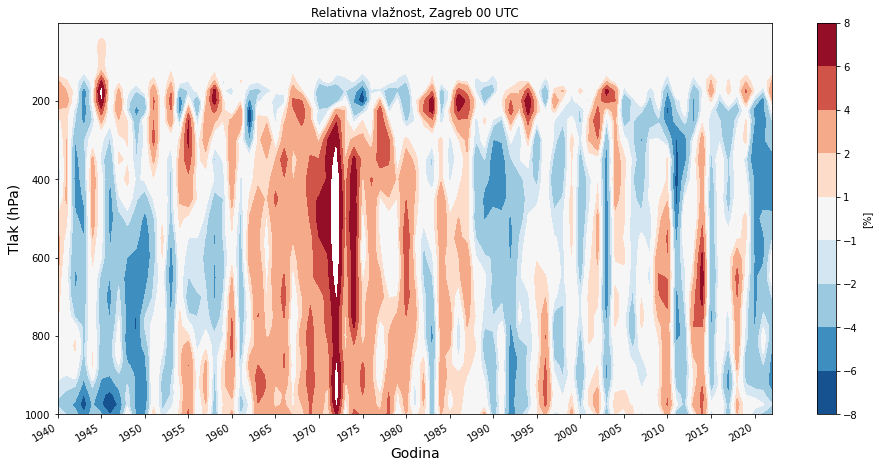

In [13]:
graph_hovmoeller(zg_rel_00, cmap_levels=hovmoeller_rel_levels, title="Relativna vlažnost, Zagreb 00 UTC", cmap_label="[%]")

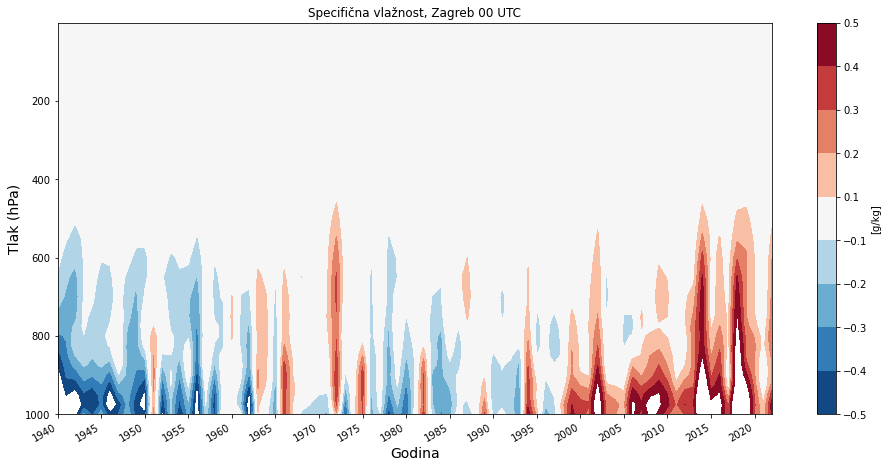

In [14]:
graph_hovmoeller(zg_spec_00, cmap_levels=hovmoeller_spec_levels, title="Specifična vlažnost, Zagreb 00 UTC", cmap_label="[g/kg]")

## Zadar 00 UTC

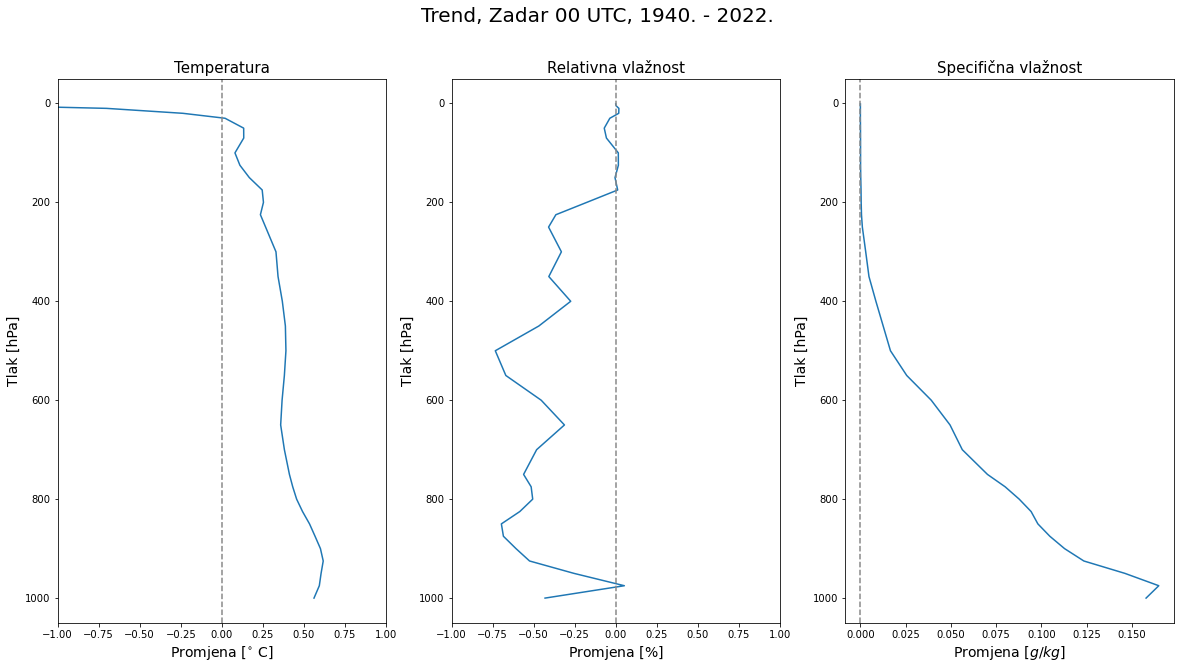

In [15]:
graph_trend(zg_temp_00, zg_rel_00, zg_spec_00, "Trend, Zadar 00 UTC, 1940. - 2022.")

plt.savefig("zd_00.png")

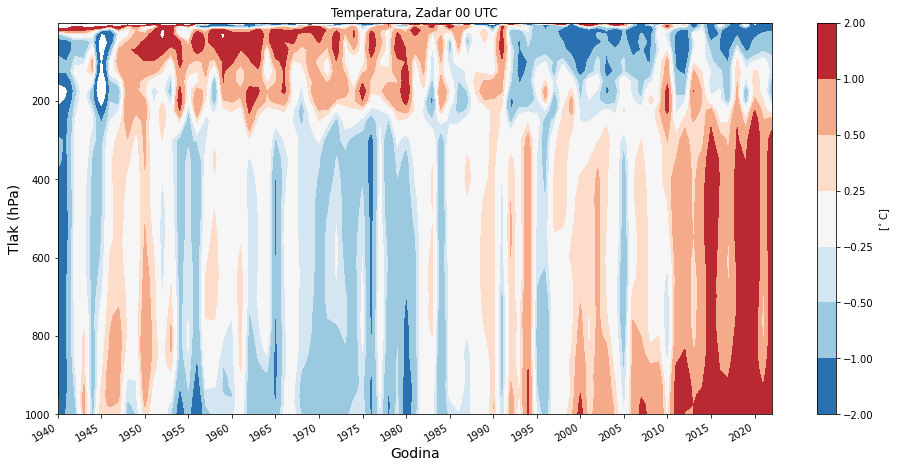

In [16]:
graph_hovmoeller(zd_temp_00, cmap_levels=hovmoeller_temp_levels, title="Temperatura, Zadar 00 UTC", cmap_label=r"[$^{\circ}$ C]")

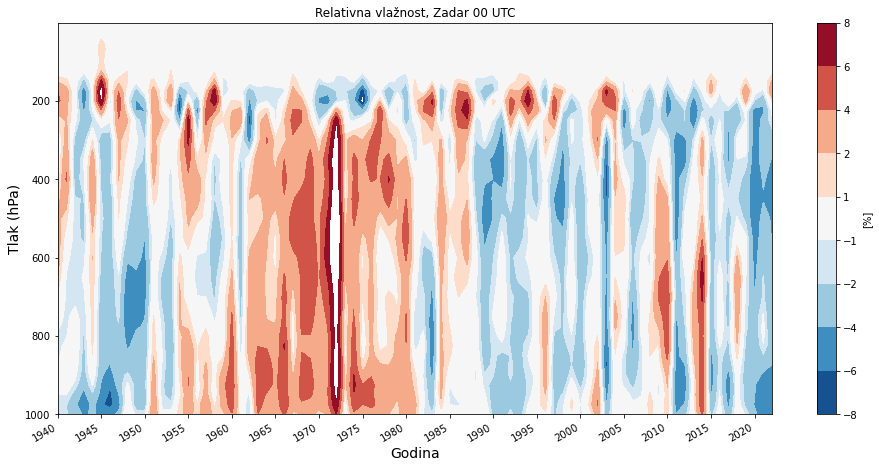

In [17]:
graph_hovmoeller(zd_rel_00, cmap_levels=hovmoeller_rel_levels, title="Relativna vlažnost, Zadar 00 UTC", cmap_label="[%]")

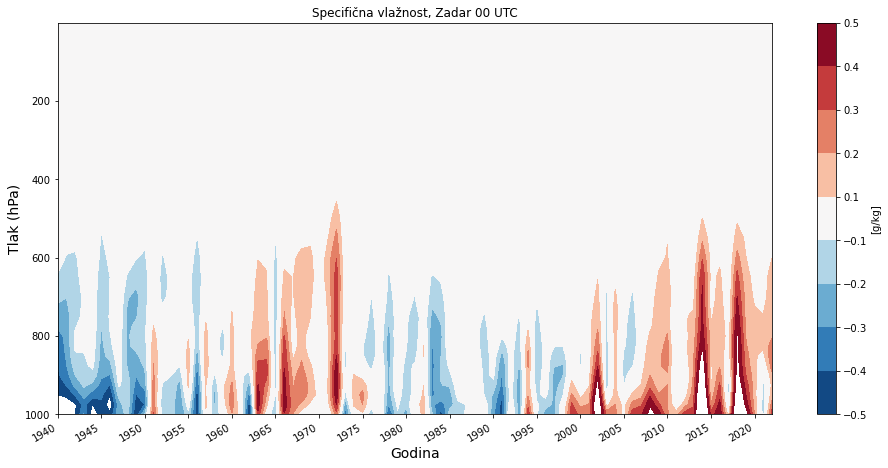

In [18]:
graph_hovmoeller(zd_spec_00, cmap_levels=hovmoeller_spec_levels, title="Specifična vlažnost, Zadar 00 UTC", cmap_label="[g/kg]")

## Zagreb 12 UTC

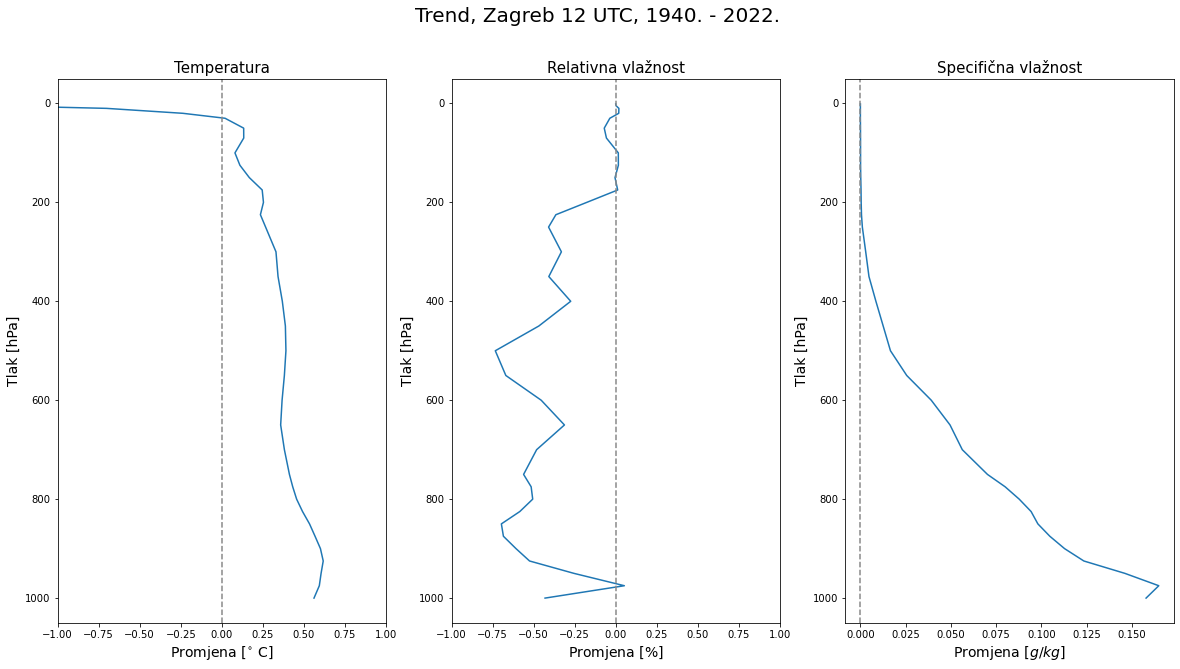

In [19]:
graph_trend(zg_temp_00, zg_rel_00, zg_spec_00, "Trend, Zagreb 12 UTC, 1940. - 2022.")

plt.savefig("zg_12.png")

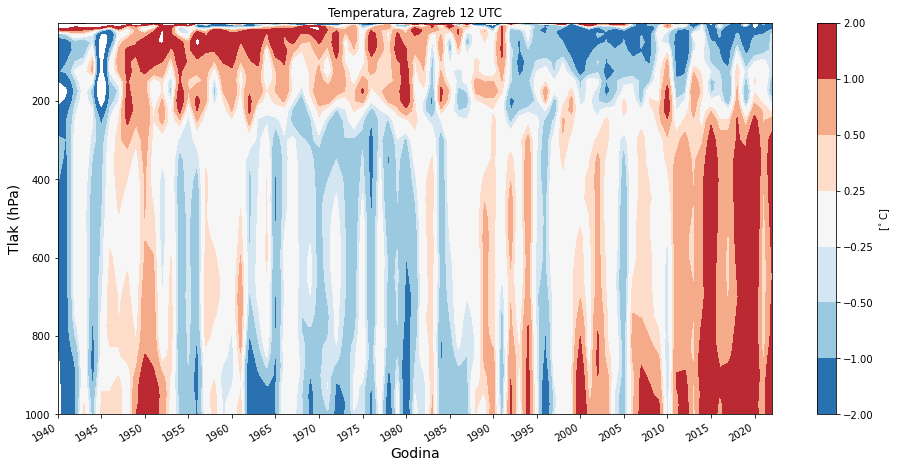

In [20]:
graph_hovmoeller(zg_temp_12, cmap_levels=hovmoeller_temp_levels, title="Temperatura, Zagreb 12 UTC", cmap_label=r"[$^{\circ}$ C]")

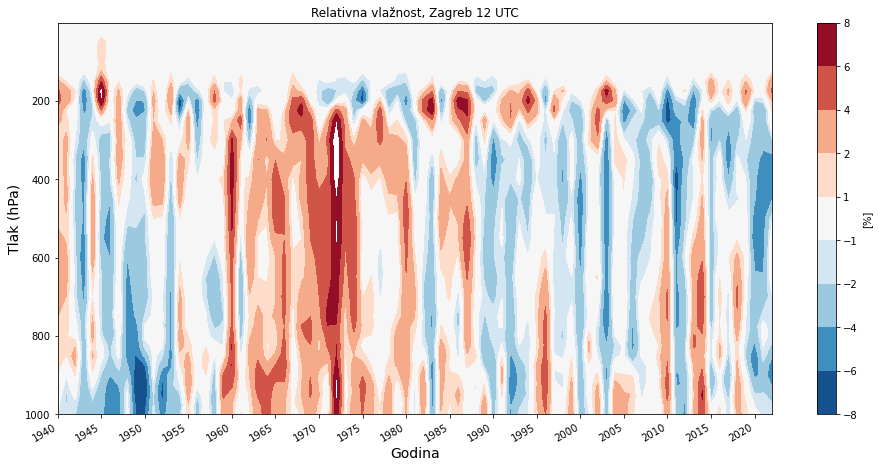

In [21]:
graph_hovmoeller(zg_rel_12, cmap_levels=hovmoeller_rel_levels, title="Relativna vlažnost, Zagreb 12 UTC", cmap_label="[%]")

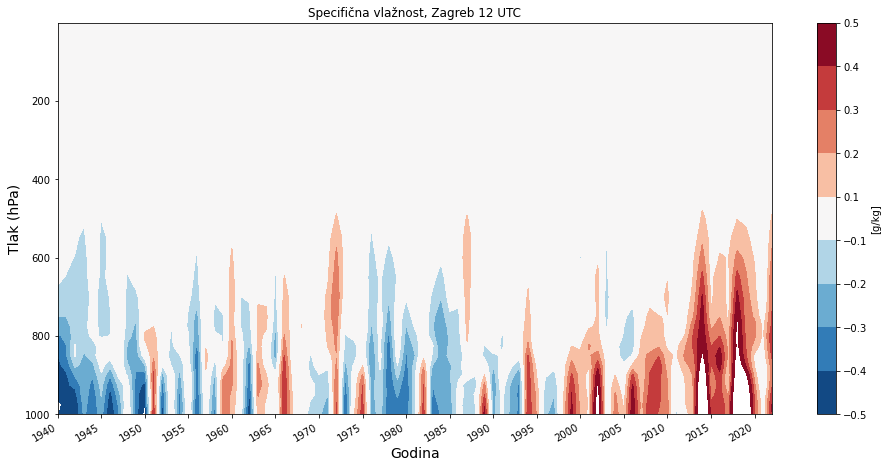

In [22]:
graph_hovmoeller(zg_spec_12, cmap_levels=hovmoeller_spec_levels, title="Specifična vlažnost, Zagreb 12 UTC", cmap_label="[g/kg]")

## Zadar 12 UTC

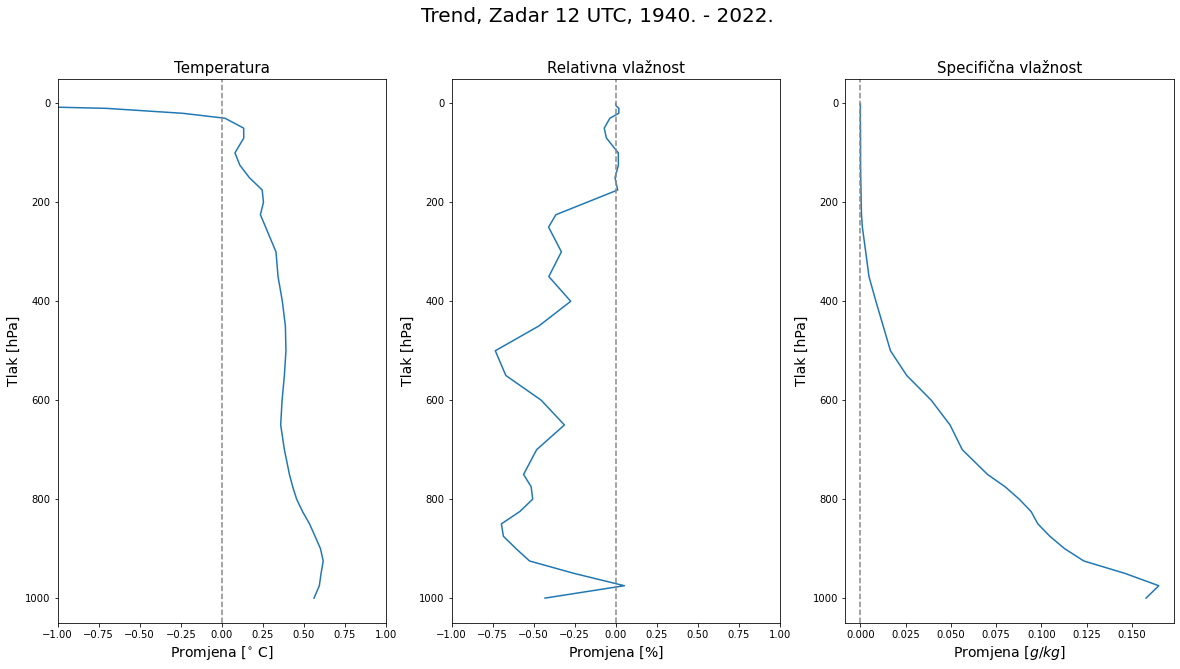

In [23]:
graph_trend(zg_temp_00, zg_rel_00, zg_spec_00, "Trend, Zadar 12 UTC, 1940. - 2022.")

plt.savefig("zd_12.png")

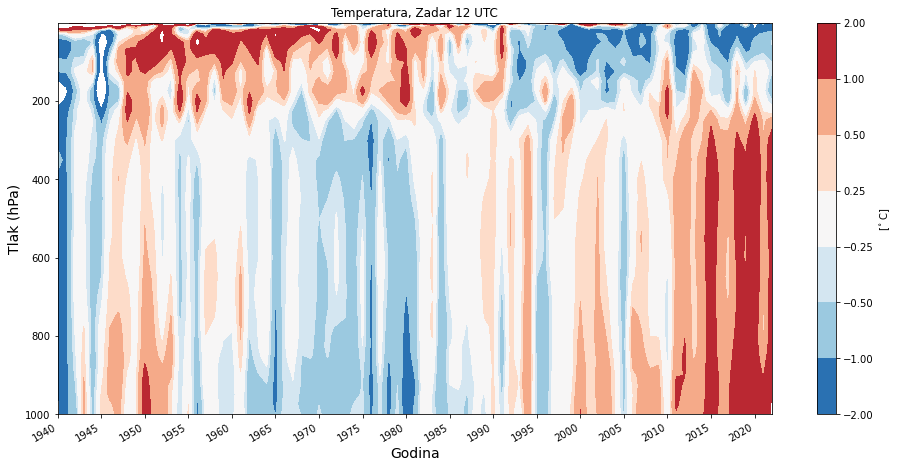

In [24]:
graph_hovmoeller(zd_temp_12, cmap_levels=hovmoeller_temp_levels, title="Temperatura, Zadar 12 UTC", cmap_label=r"[$^{\circ}$ C]")

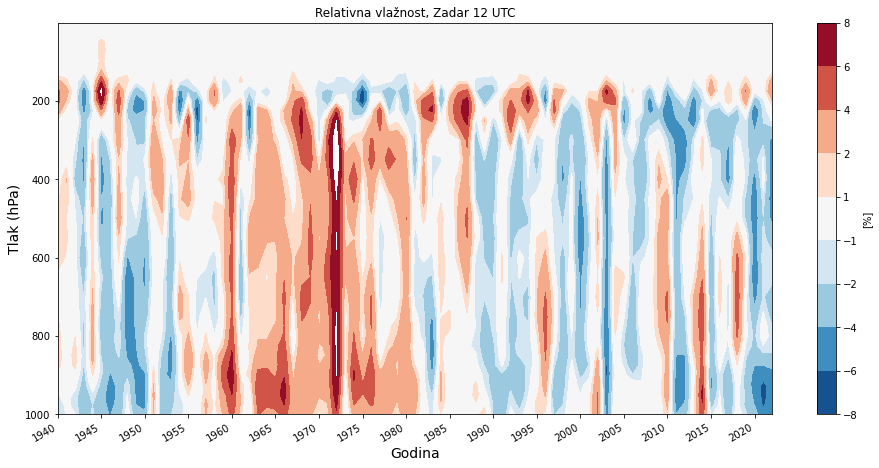

In [25]:
graph_hovmoeller(zd_rel_12, cmap_levels=hovmoeller_rel_levels, title="Relativna vlažnost, Zadar 12 UTC", cmap_label="[%]")

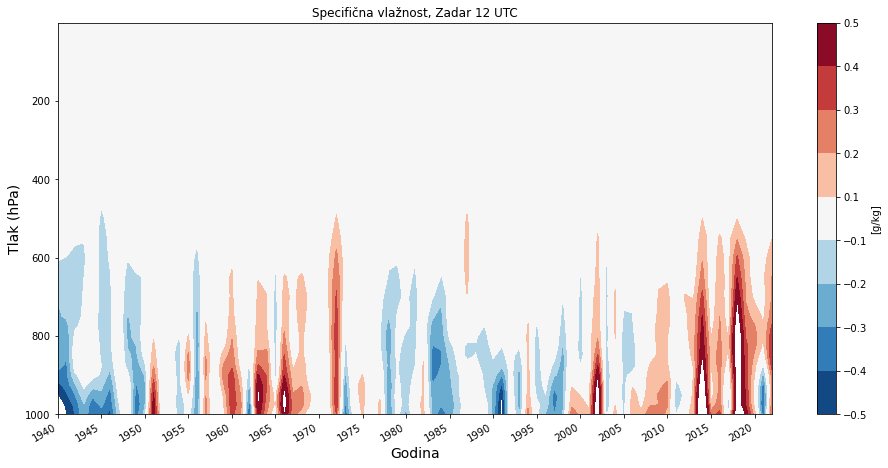

In [26]:
graph_hovmoeller(zd_spec_12, cmap_levels=hovmoeller_spec_levels, title="Specifična vlažnost, Zadar 12 UTC", cmap_label="[g/kg]")